In [9]:
import itertools
import math

import gsd.hoomd
import hoomd
import numpy
import rowan

## Overview

### Questions

* How do I input arbitrary rigid body into hoomd?

### Objectives

* Define an rigid body with an arbitrary inertia tensor.
* Reorient the rigid body so that the moment of inertia tensor is diagonalized.
* reorient constitudent particles in local coordinates.

The `render_rigid_body` function in the next (hidden) cell will render the rigid body using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [10]:
import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_rigid_body(pos_body, radius_constituent):
    '''
    outputs the sphere positions in the rigid body depending on the radius of the constituent particles
    '''
    L = 3 * numpy.max(numpy.linalg.norm(pos_body, axis=1))
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(pos_body),
                                       radius=radius_constituent)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = pos_body
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Rigid Bodies in Hoomd:

Rigid bodies in hoomd are assumed to be diagonalized meaning that their moment of inertia is defined by the principle moments with all others moments defined as zero. 

A common mistake is to take an object oriented such that the moment of inertia is not diagonalized, and defining the moments as a the principle moments of the non-diagonalized inertia tensor. 

## General way to define an arbitrary rigid body in hoomd: A Step by step guide

* Step 1: Get the inertia tensor of your rigid body (non-diagonalized)
* Step 2: Solve for the orientation of the body that diagonalizes the moment of inertia tensor
* Step 3: Reorient the rigid body so that the rigid body inertia tensor is diagonalized in global coordinates
* Step 4: Define the moments of inertia using the new diagonalized moments of inertia

We begin with the same system that we have studied in previous examples with two spheres of mass 1 and radius 1.

In contrast to other examples, we start with positions of the spheres that make the moment of inertia of the rigid body **not** diagonalized.

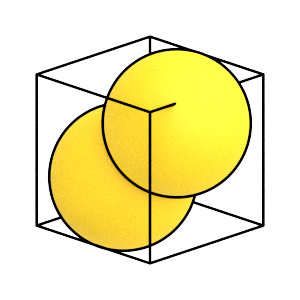

In [3]:
const_sp_pos1 = numpy.array([.5,.5,0]) 
const_sp_pos2 = numpy.array([-.5,-.5,0]) 
body_pos = numpy.array([const_sp_pos1,const_sp_pos2])
mass = 1
radius = 1

render_rigid_body(body_pos,radius)

# Step 1:

This step is well defined in tutorial 1

In [4]:
I_ref = numpy.array([[2/5*mass*radius**2,0,0],[0,2/5*mass*radius**2,0],[0,0,2/5*mass*radius**2]])

I_1 = I_ref + mass*(numpy.dot(const_sp_pos1,const_sp_pos1)*numpy.identity(3) + numpy.outer(const_sp_pos1,const_sp_pos1))
I_2 = I_ref + mass*(numpy.dot(const_sp_pos2,const_sp_pos2)*numpy.identity(3) + numpy.outer(const_sp_pos2,const_sp_pos2))

I_tot = I_1 + I_2

print('Moment of inertia tensor')
print(I_tot)

Moment of inertia tensor
[[2.3 0.5 0. ]
 [0.5 2.3 0. ]
 [0.  0.  1.8]]


**Note:** If we proceed by plugging in the diagonal components of the moment of inertia tensor into hoomd that we have above, hoomd will **incorrectly** simulate the dynamics of the rigid body. 

We first must **diagonalize** the moment of inertia and **reorient** the constituent particles of the rigid body. 

# Step 2:

In order to diagonalize the moment of inertia the procedure is as follows: 

### Step 2a: Get the Eigenvalues and Eigenvectors of the Inertia Tensor

The eigenvalues of the moment of non-diagonalized inertia tensor are the diagonalized principle moments of inertia. 

The eigenvalues are solved for using a numerical eigenvalue solver, in this case using the numpy linear algebra toolbox.

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

### step 2b: Transpose the Eigenvectors to get the rotation matrix

The transpose of the eigenvectors is the rotation matrix to rotate the original particles into the frame where the inertia tensor from the frame of reference of the simulation is diagonalized.

Additional information about this procedure is given here. 
https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Graduate_Classical_Mechanics_(Fowler)/24%3A_Motion_of_a_Rigid_Body_-_the_Inertia_Tensor/24.08%3A_Diagonalizing_the_Inertia_Tensor


# Step 3: Rotate the particles in the rigid body

Rotating a rigid body by the rotation matrix by taking the dot product between the rotation matrix and the original position vectors of the particles. 

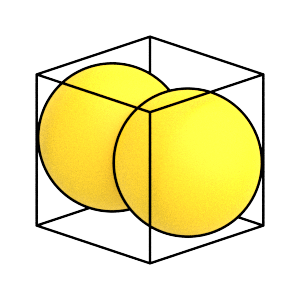

In [5]:
# Step 2a:

I_prin, E_vec = numpy.linalg.eig(I_tot)

# Step 2b: 

R = numpy.transpose(E_vec)

# Step 3
const_sp_pos1_new =numpy.dot(R,numpy.transpose(numpy.array([const_sp_pos1])))[:,0]
const_sp_pos2_new =numpy.dot(R,numpy.transpose(numpy.array([const_sp_pos2])))[:,0]

render_rigid_body(numpy.array([const_sp_pos1_new,const_sp_pos2_new]),radius)

We can now confirm that the principle moments of inertia from the eigenvalue problem match the moment of inertia tensor of the rotated position of our spherical particles that make up the rigid body. 

In [11]:
print('Eigenvalues = Principle moments of inertia')

print(I_prin)

Eigenvalues = Principle moments of inertia
[2.8 1.8 1.8]


In [7]:
I_1_new = I_ref + mass*(numpy.dot(const_sp_pos1_new,const_sp_pos1_new)*numpy.identity(3) + numpy.outer(const_sp_pos1_new,const_sp_pos1_new))
I_2_new = I_ref + mass*(numpy.dot(const_sp_pos2_new,const_sp_pos2_new)*numpy.identity(3) + numpy.outer(const_sp_pos2_new,const_sp_pos2_new))

I_tot_new = I_1_new + I_2_new

In [8]:
print('New moment of inertia tensor')
print(I_tot_new)

New moment of inertia tensor
[[2.80000000e+00 1.57009246e-16 0.00000000e+00]
 [1.57009246e-16 1.80000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80000000e+00]]


## Note:

The new moment of inertia tensor is zero everywhere (w/in numerical error) except for the diagonal elements of the tensor. 

Furthermore, those elements are the exact same as the eigenvalues obtained from the non-diagonalized matrix. 